In [38]:
# global imports
import numpy as np
import pandas as pd
import tensorflow as tf

In [39]:
# instantiate pathway variables
projectDir = 'D:\mattp\Documents\School\SeniorYear\DataAnalysis'

#KHDir = projectDir + '\KHresamplePAandWthr-1217_0118.csv'
dataDir = projectDir + '\WaterStreetPA_WthrMETAR_SNOW-2018.csv'

# read in data
#KHData = pd.read_csv(KHDir,header=0)
Data = pd.read_csv(dataDir,header=0)

In [43]:
Data.shape
print(Data.columns)
Data['Clds10000'][30000:30050]
Data.datetime.values[1]
#features = pd.concat([dtEmumeratedDf, encodedWindDirDf, Data.temperatureF, Data.dewpointF, Data.humidityPCNT, Data.wind_speedMPH, Data.wind_gustsMPH, Data.pressureIN, Data.precipIN,Data.PM25],axis=1)

Index(['Unnamed: 0', 'datetime', 'created_at', 'PM25', 'Date', 'temp',
       'dewpoint', 'RH', 'windDIR', 'windMPH', 'precip', 'mslp', 'visibility',
       'gust', 'wxcodes', '(top) Snow Depth (in)', '(middle) Snow Depth (in)',
       '(bottom) Snow Depth (in)', '(top) Snow Temp. (deg. F)',
       '(middle) Snow Temp. (deg. F)', '(bottom) Snow Temp. (deg. F)',
       '(top) Snow Density (%)', '(middle) Snow Density (%)',
       '(bottom) Snow Density (%)', 'Date w/o Time', 'Hour',
       'Forecasted from 0 UTC', 'FEW', 'SCT', 'BKN', 'OVC', 'VV', 'Clouds',
       'Clds1000', 'Clds2000', 'Clds3000', 'Clds4000', 'Clds5000', 'Clds6000',
       'Clds7000', 'Clds8000', 'Clds9000', 'Clds10000'],
      dtype='object')


'2018-02-22 17:55:54'

In [67]:
# data preprocessing

# process datetime
import datetime as dt
dtParsed = [0 for i in range(Data.shape[0])]
for i in range(Data.shape[0]):
    dtParsed[i] = dt.datetime.strptime(Data.datetime.values[i], '%Y-%m-%d %H:%M:%S')

# enumerate time of day
dtEnumerated = [0 for i in range(Data.shape[0])]
for i in range(Data.shape[0]):
    dtEnumerated[i] = dtParsed[i].hour*3600 + dtParsed[i].minute*60 + dtParsed[i].second
dtEmumeratedDf = pd.DataFrame(dtEnumerated)

# drop out bad rows
Data.reset_index(drop=True, inplace=True)
    
# combine features and output for scaling
features = pd.concat([dtEmumeratedDf, Data.temp, Data.dewpoint, Data.RH, 
                    Data.windDIR, Data.windMPH, Data.precip, Data.mslp,
                    Data.visibility, Data.gust, Data['(top) Snow Depth (in)'],
                    Data['(middle) Snow Depth (in)'], Data['(bottom) Snow Depth (in)'],
                    Data['(top) Snow Temp. (deg. F)'], Data['(middle) Snow Temp. (deg. F)'],
                    Data['(bottom) Snow Temp. (deg. F)'], Data['(top) Snow Density (%)'],
                    Data['(middle) Snow Density (%)'], Data['(bottom) Snow Density (%)'],
                    Data.FEW, Data.SCT, Data.BKN, Data.OVC, Data.VV, Data.Clouds, 
                    Data.Clds1000, Data.Clds2000, Data.Clds3000, Data.Clds4000, Data.Clds5000,
                    Data.Clds6000, Data.Clds7000, Data.Clds8000, Data.Clds9000, Data.Clds10000],axis=1)

In [92]:
features.fillna(0, inplace = True)

'''# scale features to adjust for BAM benchmarks
coefficients = [1, 0.136378, 1, 1, 1, 1, -0.041879, 1, -0.495839]
for i in range(0,len(coefficients)):
     features[i] = features[i].multiply(coefficients[i])'''

# scaling for normalization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scaled = sc.fit_transform(features)

# seperate scaled data(X) and output(y)
X = features
y = Data.PM25 * 0.401344

KeyError: 1

In [82]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [83]:
# instantiate regressor model
from keras import Sequential
from keras.layers import Dense
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(100, input_dim=35, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(100, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(75, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(50, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(1, kernel_initializer='normal'))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
    return regressor

# select batch size, epochs, validation set size
from keras.wrappers.scikit_learn import KerasRegressor
regressor = KerasRegressor(build_fn=build_regressor, batch_size=64,epochs=50,validation_split=0.2)

In [84]:
# train model
log = regressor.fit(X_train,y_train)

Train on 211849 samples, validate on 52963 samples
Epoch 1/50
211849/211849 [==============================] - 11s 54us/step - loss: 15.7370 - mean_absolute_error: 2.6386 - acc: 1.4161e-05 - val_loss: 13.8258 - val_mean_absolute_error: 2.4417 - val_acc: 0.0000e+00
Epoch 2/50
211849/211849 [==============================] - 11s 51us/step - loss: 14.4131 - mean_absolute_error: 2.4915 - acc: 1.4161e-05 - val_loss: 14.2329 - val_mean_absolute_error: 2.3096 - val_acc: 1.5105e-04
Epoch 3/50
211849/211849 [==============================] - 11s 52us/step - loss: 12.9454 - mean_absolute_error: 2.2854 - acc: 3.3042e-05 - val_loss: 46.0906 - val_mean_absolute_error: 4.9578 - val_acc: 0.0000e+00
Epoch 4/50
211849/211849 [==============================] - 11s 54us/step - loss: 12.5863 - mean_absolute_error: 2.2353 - acc: 9.4407e-06 - val_loss: 10.2690 - val_mean_absolute_error: 2.0398 - val_acc: 5.6643e-05
Epoch 5/50
211849/211849 [==============================] - 11s 53us/step - loss: 11.8946 - m

211849/211849 [==============================] - 20s 94us/step - loss: 9.3222 - mean_absolute_error: 1.7791 - acc: 1.1329e-04 - val_loss: 8.2535 - val_mean_absolute_error: 1.7565 - val_acc: 7.5524e-05.7798 - acc: 1.1
Epoch 39/50
211849/211849 [==============================] - 13s 63us/step - loss: 9.2690 - mean_absolute_error: 1.7729 - acc: 8.4966e-05 - val_loss: 8.3263 - val_mean_absolute_error: 1.7303 - val_acc: 5.6643e-05
Epoch 40/50
211849/211849 [==============================] - 15s 71us/step - loss: 9.2883 - mean_absolute_error: 1.7717 - acc: 8.4966e-05 - val_loss: 9.3087 - val_mean_absolute_error: 1.9518 - val_acc: 1.8881e-05
Epoch 41/50
211849/211849 [==============================] - 12s 57us/step - loss: 9.1888 - mean_absolute_error: 1.7596 - acc: 1.1329e-04 - val_loss: 8.1067 - val_mean_absolute_error: 1.7467 - val_acc: 1.8881e-05
Epoch 42/50
211849/211849 [==============================] - 14s 65us/step - loss: 9.1690 - mean_absolute_error: 1.7554 - acc: 8.9687e-05 - val_

NameError: name 'plt' is not defined

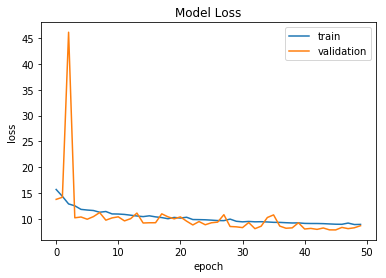

In [86]:
import matplotlib.pyplot as plt

# loss plot
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [87]:
# make predictions
y_pred = regressor.predict(X_test)

In [89]:
# plot predicitons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
# configure scatterplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.25)
ax1.scatter(y_test, y_pred,5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax1.set_xlabel('Measured')
ax1.set_ylabel('Predicted')
ax1.set_ylim([0,0.3])
ax1.set_xlim([0,0.31])
ax1.set_title('Measured vs Prediction Scatterplot')

# configure 2d histogram
# cmap initialization
#heatMap = cm.get_cmap('hot_r',9500)
#newColors = heatMap(np.linspace(0, 1,9500))
#grey = np.array([0.941, 0.941, 0.941,1])
#newColors[1:19,:] = grey
#newHeatMap = ListedColormap(newColors)
# histogram initialization
hist = ax2.hist2d(y_test,y_pred,bins=[10,10],cmap='hot_r')
ax2.set_ylim([0,0.3])
ax2.set_xlim([0,0.27])
fig.colorbar(hist[3], ax = ax2)
ax2.set_xlabel('Measured')
ax2.set_ylabel('Predicted')
ax2.set_title('Measured vs Prediction Histogram')

plt.show()

ValueError: Image size of 210838x23476 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x360 with 3 Axes>